In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'JBLU Variation 6 LSTM Time Series'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Jet Blue Stock Data

### No other stock price

In [5]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/JBLU_data.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2002-05-02,14.761481,13.724947,-5.141986,58104336.0,2.0
2002-05-03,14.562963,13.853872,-13.413429,57315261.0,2.0
2002-05-06,15.419259,14.094701,-0.086583,58757399.0,0.0
2002-05-07,16.148148,14.410616,-4.436861,61163774.0,2.0
2002-05-08,14.696296,14.454567,-37.883964,57784724.0,2.0


In [6]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [7]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(4175, 15, 4)

In [8]:
y = labels
y = np.array(y)
y.shape

(4175,)

In [9]:
from collections import Counter

Counter(y)

Counter({2.0: 3801, 0.0: 191, 1.0: 183})

In [10]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [11]:
SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

In [12]:
import time

EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [13]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [15]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
27/27 [==============================] - 1s 36ms/step - loss: 0.2954 - accuracy: 0.5240 - mse: 0.4366 - weighted_accuracy: 0.3266 - weighted_mse: 0.5115 - val_loss: 0.3001 - val_accuracy: 0.0431 - val_mse: 0.3519 - val_weighted_accuracy: 0.0431 - val_weighted_mse: 0.3519
Epoch 2/200
27/27 [==============================] - 0s 10ms/step - loss: 0.2146 - accuracy: 0.3713 - mse: 0.7316 - weighted_accuracy: 0.4457 - weighted_mse: 0.7193 - val_loss: 0.2934 - val_accuracy: 0.0443 - val_mse: 0.3776 - val_weighted_accuracy: 0.0443 - val_weighted_mse: 0.3776
Epoch 3/200
27/27 [==============================] - 0s 10ms/step - loss: 0.1913 - accuracy: 0.3216 - mse: 0.9504 - weighted_accuracy: 0.4956 - weighted_mse: 0.9197 - val_loss: 0.2855 - val_accuracy: 0.0443 - val_mse: 0.4121 - val_weighted_accuracy: 0.0443 - val_weighted_mse: 0.4121
Epoch 4/200
27/27 [==============================] - 0s 10ms/step - loss: 0.1816 - accuracy: 0.2796 - mse: 1.1029 - weighted_accuracy: 0.5290 - weig

Epoch 30/200
27/27 [==============================] - 0s 11ms/step - loss: 0.1342 - accuracy: 0.3787 - mse: 1.7283 - weighted_accuracy: 0.7025 - weighted_mse: 1.6378 - val_loss: 0.1925 - val_accuracy: 0.3269 - val_mse: 1.7113 - val_weighted_accuracy: 0.3269 - val_weighted_mse: 1.7113
Epoch 31/200
27/27 [==============================] - 0s 11ms/step - loss: 0.1334 - accuracy: 0.4138 - mse: 1.6912 - weighted_accuracy: 0.7222 - weighted_mse: 1.6035 - val_loss: 0.1904 - val_accuracy: 0.3713 - val_mse: 1.7120 - val_weighted_accuracy: 0.3713 - val_weighted_mse: 1.7120
Epoch 32/200
27/27 [==============================] - 0s 11ms/step - loss: 0.1321 - accuracy: 0.4272 - mse: 1.7419 - weighted_accuracy: 0.7184 - weighted_mse: 1.6783 - val_loss: 0.1840 - val_accuracy: 0.4263 - val_mse: 1.5974 - val_weighted_accuracy: 0.4263 - val_weighted_mse: 1.5974
Epoch 33/200
27/27 [==============================] - 0s 11ms/step - loss: 0.1330 - accuracy: 0.3751 - mse: 1.7691 - weighted_accuracy: 0.7224 - 

Epoch 59/200
27/27 [==============================] - 0s 11ms/step - loss: 0.1147 - accuracy: 0.5769 - mse: 2.0481 - weighted_accuracy: 0.7990 - weighted_mse: 2.0571 - val_loss: 0.1978 - val_accuracy: 0.4275 - val_mse: 2.2017 - val_weighted_accuracy: 0.4275 - val_weighted_mse: 2.2017
Epoch 60/200
27/27 [==============================] - 0s 11ms/step - loss: 0.1124 - accuracy: 0.5485 - mse: 2.1457 - weighted_accuracy: 0.8072 - weighted_mse: 2.1331 - val_loss: 0.1777 - val_accuracy: 0.5030 - val_mse: 2.1135 - val_weighted_accuracy: 0.5030 - val_weighted_mse: 2.1135
Epoch 61/200
27/27 [==============================] - 0s 11ms/step - loss: 0.1159 - accuracy: 0.5114 - mse: 2.1150 - weighted_accuracy: 0.7768 - weighted_mse: 2.1087 - val_loss: 0.1975 - val_accuracy: 0.4419 - val_mse: 2.2178 - val_weighted_accuracy: 0.4419 - val_weighted_mse: 2.2178
Epoch 62/200
27/27 [==============================] - 0s 11ms/step - loss: 0.1122 - accuracy: 0.5359 - mse: 2.1663 - weighted_accuracy: 0.8005 - 

Epoch 88/200
27/27 [==============================] - 0s 12ms/step - loss: 0.0951 - accuracy: 0.6575 - mse: 2.6167 - weighted_accuracy: 0.8597 - weighted_mse: 2.6725 - val_loss: 0.1628 - val_accuracy: 0.6000 - val_mse: 2.7669 - val_weighted_accuracy: 0.6000 - val_weighted_mse: 2.7669
Epoch 89/200
27/27 [==============================] - 0s 13ms/step - loss: 0.0960 - accuracy: 0.6464 - mse: 2.6635 - weighted_accuracy: 0.8559 - weighted_mse: 2.6906 - val_loss: 0.1872 - val_accuracy: 0.5257 - val_mse: 2.7706 - val_weighted_accuracy: 0.5257 - val_weighted_mse: 2.7706
Epoch 90/200
27/27 [==============================] - 0s 12ms/step - loss: 0.0978 - accuracy: 0.6737 - mse: 2.6150 - weighted_accuracy: 0.8549 - weighted_mse: 2.6615 - val_loss: 0.2052 - val_accuracy: 0.4599 - val_mse: 2.8075 - val_weighted_accuracy: 0.4599 - val_weighted_mse: 2.8075
Epoch 91/200
27/27 [==============================] - 0s 12ms/step - loss: 0.0946 - accuracy: 0.6677 - mse: 2.5819 - weighted_accuracy: 0.8553 - 

Epoch 117/200
27/27 [==============================] - 0s 11ms/step - loss: 0.0778 - accuracy: 0.7482 - mse: 3.1910 - weighted_accuracy: 0.9015 - weighted_mse: 3.3414 - val_loss: 0.1852 - val_accuracy: 0.5820 - val_mse: 3.2381 - val_weighted_accuracy: 0.5820 - val_weighted_mse: 3.2381
Epoch 118/200
27/27 [==============================] - 0s 11ms/step - loss: 0.0813 - accuracy: 0.7078 - mse: 3.2662 - weighted_accuracy: 0.8868 - weighted_mse: 3.3679 - val_loss: 0.1810 - val_accuracy: 0.5940 - val_mse: 3.1856 - val_weighted_accuracy: 0.5940 - val_weighted_mse: 3.1856
Epoch 119/200
27/27 [==============================] - 0s 11ms/step - loss: 0.0789 - accuracy: 0.7446 - mse: 3.2789 - weighted_accuracy: 0.8917 - weighted_mse: 3.4086 - val_loss: 0.2017 - val_accuracy: 0.5832 - val_mse: 3.2519 - val_weighted_accuracy: 0.5832 - val_weighted_mse: 3.2519
Epoch 120/200
27/27 [==============================] - 0s 11ms/step - loss: 0.0834 - accuracy: 0.7021 - mse: 3.3035 - weighted_accuracy: 0.870

Epoch 146/200
27/27 [==============================] - 0s 15ms/step - loss: 0.0665 - accuracy: 0.7811 - mse: 4.0336 - weighted_accuracy: 0.9114 - weighted_mse: 4.1646 - val_loss: 0.1655 - val_accuracy: 0.6958 - val_mse: 4.1905 - val_weighted_accuracy: 0.6958 - val_weighted_mse: 4.1905
Epoch 147/200
27/27 [==============================] - 0s 16ms/step - loss: 0.0652 - accuracy: 0.7901 - mse: 4.0140 - weighted_accuracy: 0.9168 - weighted_mse: 4.1278 - val_loss: 0.1751 - val_accuracy: 0.6515 - val_mse: 3.9408 - val_weighted_accuracy: 0.6515 - val_weighted_mse: 3.9408
Epoch 148/200
27/27 [==============================] - 0s 17ms/step - loss: 0.0743 - accuracy: 0.7509 - mse: 3.9395 - weighted_accuracy: 0.8918 - weighted_mse: 4.0611 - val_loss: 0.1950 - val_accuracy: 0.6048 - val_mse: 4.1298 - val_weighted_accuracy: 0.6048 - val_weighted_mse: 4.1298
Epoch 149/200
27/27 [==============================] - 0s 16ms/step - loss: 0.0698 - accuracy: 0.7877 - mse: 4.0909 - weighted_accuracy: 0.905

Epoch 175/200
27/27 [==============================] - 0s 16ms/step - loss: 0.0586 - accuracy: 0.8063 - mse: 4.8423 - weighted_accuracy: 0.9248 - weighted_mse: 4.9938 - val_loss: 0.1771 - val_accuracy: 0.7090 - val_mse: 5.2703 - val_weighted_accuracy: 0.7090 - val_weighted_mse: 5.2703
Epoch 176/200
27/27 [==============================] - 0s 15ms/step - loss: 0.0637 - accuracy: 0.7997 - mse: 4.7871 - weighted_accuracy: 0.9119 - weighted_mse: 4.9062 - val_loss: 0.1874 - val_accuracy: 0.6922 - val_mse: 5.3425 - val_weighted_accuracy: 0.6922 - val_weighted_mse: 5.3425
Epoch 177/200
27/27 [==============================] - 0s 16ms/step - loss: 0.0593 - accuracy: 0.8081 - mse: 4.9556 - weighted_accuracy: 0.9276 - weighted_mse: 5.0557 - val_loss: 0.1698 - val_accuracy: 0.7365 - val_mse: 5.3597 - val_weighted_accuracy: 0.7365 - val_weighted_mse: 5.3597
Epoch 178/200
27/27 [==============================] - 0s 16ms/step - loss: 0.0548 - accuracy: 0.8240 - mse: 4.9643 - weighted_accuracy: 0.929

In [16]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.17055492103099823
Test accuracy: 0.7461077570915222


In [17]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.4781685  -3.891839    2.1068375 ]
 [-2.612787   -2.4501784   0.9981564 ]
 [-2.9461904  -0.9513889  -0.17019354]
 ...
 [-1.3616798  -2.1218781   0.38462102]
 [-2.7199707  -3.730145    1.6931819 ]
 [-1.3658397  -5.459437    0.19789983]]


Counter({2: 674, 1: 83, 0: 78})

In [18]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 760, 1: 37, 0: 38})

In [19]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 835
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 32
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 30
actual holds but predicted buy: 78
actual holds but predicted sell: 70
actual predicted holds: 612
Percentage buys correct: 10.81081081081081%
Percentage sells correct: 18.42105263157895%
Percentage holds correct: 80.52631578947368%
actual buys: 37
actual sells: 38
actual holds: 760


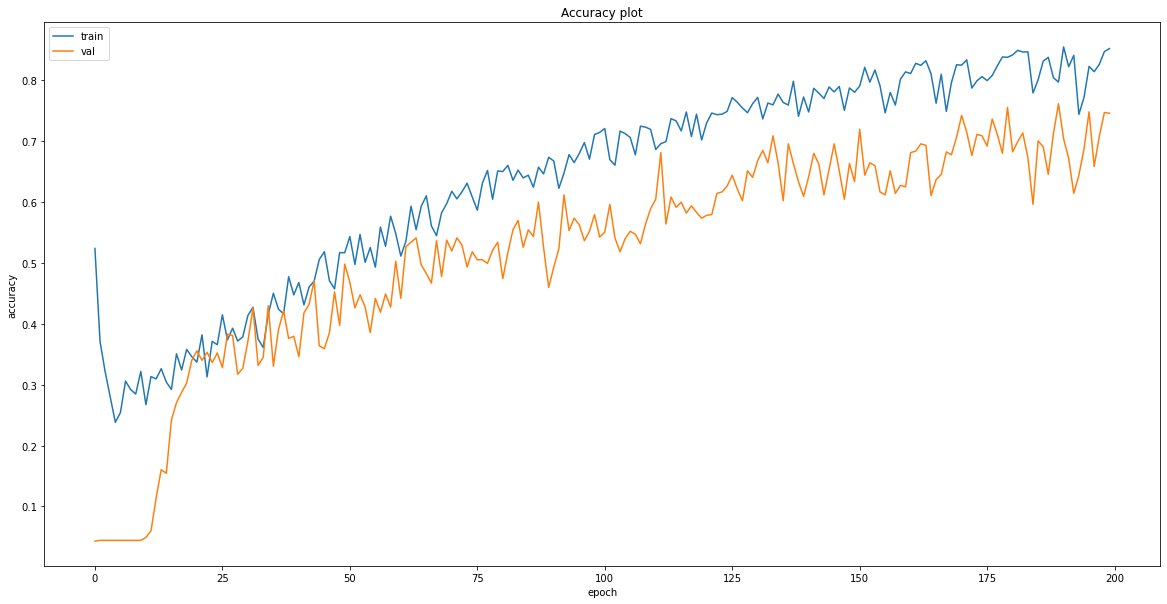

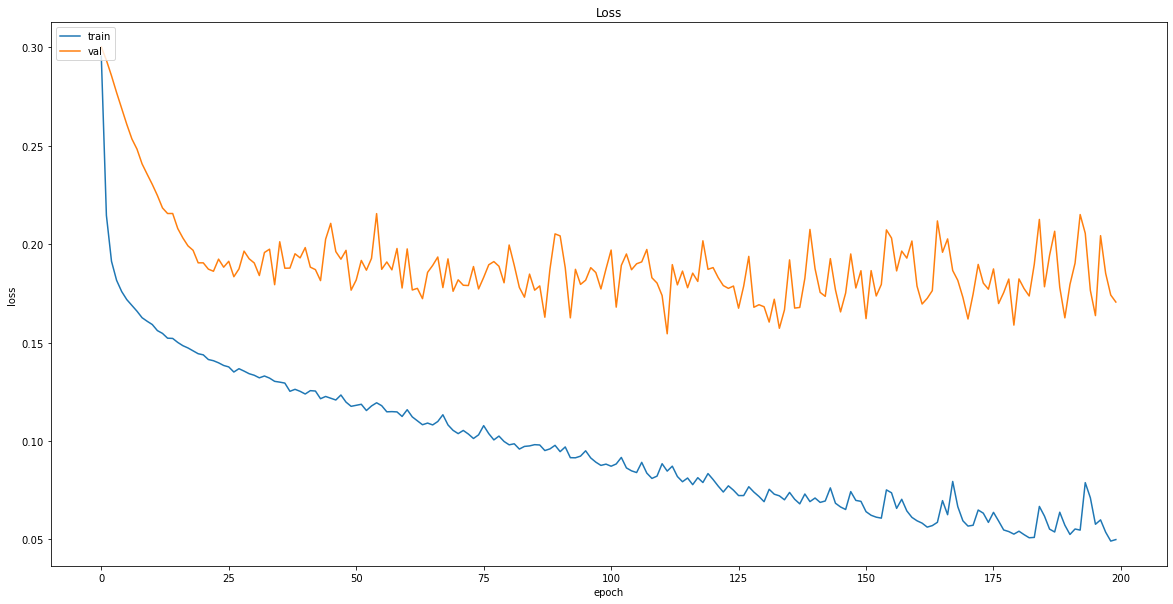

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
# Save model
model.save("models/{}".format('JBLU_no_support_time_series_lstm_buy_hold_sell.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/JBLU_no_support_time_series_lstm_buy_hold_sell.model\assets


### Test Performance

### Non-Recession Test Data

In [22]:
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
log  = pd.DataFrame(columns = column_names)
logger = []

In [23]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/JBLU_data_test.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-01-22,17.600000,17.005903,-4.149392,23132100.0,2.0
2019-01-23,17.370001,17.061918,-14.049519,19087600.0,2.0
2019-01-24,17.240000,17.089315,-19.421466,14999400.0,2.0
2019-01-25,18.120001,17.247882,-5.555506,23032100.0,2.0
2019-01-28,17.709999,17.318977,-26.363710,14531900.0,2.0


In [24]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [25]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(218, 15, 4)

In [26]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [27]:
model = tf.keras.models.load_model("models/JBLU_no_support_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1684 - accuracy: 0.6789 - mean_squared_error: 5.3895 - weighted_accuracy: 0.6789 - weighted_mean_squared_error: 5.3895
Test loss: 0.16837622225284576
Test accuracy: 0.6788991093635559


In [28]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 158, 1: 37, 0: 23})

In [29]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({0: 8, 2: 200, 1: 10})

In [30]:
df = pd.read_csv("data/variation 6/initial_indicators/JBLU_data_test.csv")
df.set_index('Date', inplace=True)

In [31]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-08,18.139999,17.903641,-27.397251,12616300.0,2.0,2,0
2019-02-11,18.260000,17.940004,-24.657592,14449900.0,0.0,2,2
2019-02-12,17.889999,17.989234,-16.438351,18367600.0,2.0,2,2
2019-02-13,18.049999,17.973967,-53.508854,14230800.0,2.0,2,2
2019-02-14,18.080000,17.985665,-50.000106,18206400.0,2.0,2,2


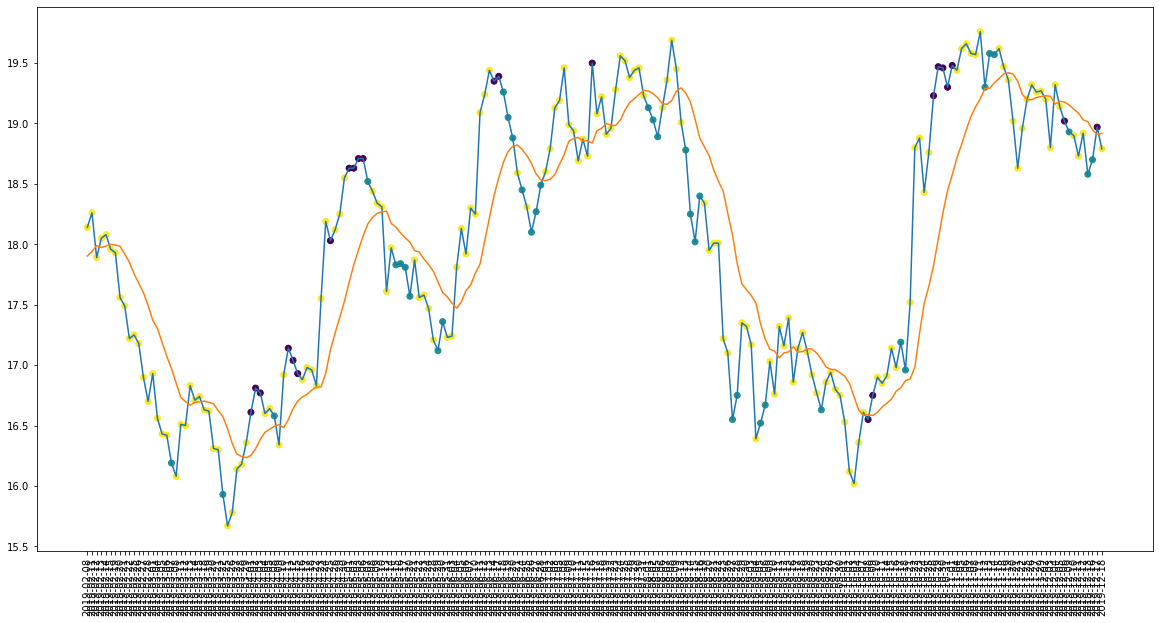

In [32]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [33]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 7
actual holds but predicted buy: 34
actual holds but predicted sell: 22
actual predicted holds: 144
Percentage buys correct: 30.0%
Percentage sells correct: 12.5%
Percentage holds correct: 72.0%
actual buys: 10
actual sells: 8
actual holds: 200


In [34]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[17.489999771118164, 17.559999465942386, 17.889999389648438, 17.93000030517578, 17.959999084472656, 18.049999237060547, 18.07999992370605, 18.13999938964844, 18.26000022888184]
[16.700000762939453, 16.899999618530273, 16.930000305175778, 17.180000305175778, 17.219999313354492, 17.25, 17.489999771118164, 17.559999465942386, 17.93000030517578]
Percentage buys correct: 62.16216216216216%
Percentage sells correct: 73.91304347826087%
Percentage holds correct: 85.44303797468355%


In [35]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $16.190000534057614
Shares owned at the moment: 615
Cash capital at the moment: $15.768333151341722


Stop Loss Activated!

Share price: $15.670000076293945
Shares owned at the moment: 0
Cash capital at the moment: $9626.316492443086


Share price: $16.579999923706055
Shares owned at the moment: 579
Cash capital at the moment: $0.09703173875823268


Price increase from previously bought: 8.447251178750136%
Share price: $18.030000686645508
Shares owned at the moment: 0
Cash capital at the moment: $10410.759160713196


Share price: $18.520000457763672
Shares owned at the moment: 560
Cash capital at the moment: $11.038103660583147


Stop Loss Activated!

Share price: $17.610000610351562
Shares owned at the moment: 0
Cash capital at the moment: $9845.519044517516


Share price: $17.829999923706055
Shares owned at the moment: 550
Cash capital at the moment: $12.051211594580309


Stop Loss Activated!

Share price: $17.209999084472653
Shares owned at the moment: 0
Cash capital at

In [36]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10301.095769746778
profit gained: 3.010957697467784%


In [37]:
logger

[0.6788991093635559,
 '30.0%',
 '12.5%',
 '72.0%',
 '62.16216216216216%',
 '73.91304347826087%',
 '85.44303797468355%',
 '-3.129409973249549%',
 '3.010957697467784%']

In [38]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.678899,30.0%,12.5%,72.0%,62.16216216216216%,73.91304347826087%,85.44303797468355%,-3.129409973249549%,3.010957697467784%


### Recession Test Data

In [39]:
logger = []

In [40]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/JBLU_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    19.049999  18.785034 -29.629734  -5172900.0     2.0
2020-01-23    19.790001  18.939644 -15.920381   7229600.0     0.0
2020-01-24    21.070000  19.267391  -2.622949  23219300.0     2.0
2020-01-27    20.650000  19.480100 -18.060233  11950900.0     2.0
2020-01-28    20.040001  19.566239 -38.461529   3416600.0     2.0


In [41]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [42]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(219, 15, 4)

In [43]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [44]:
model = tf.keras.models.load_model("models/JBLU_no_support_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1438 - accuracy: 0.7991 - mean_squared_error: 6.0721 - weighted_accuracy: 0.7991 - weighted_mean_squared_error: 6.0721
Test loss: 0.14378507435321808
Test accuracy: 0.7990867495536804


In [45]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 195, 1: 14, 0: 10})

In [46]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [47]:
df = pd.read_csv("data/variation 6/initial_indicators/JBLU_data_test2.csv")
df.set_index('Date', inplace=True)

In [48]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-10,20.020000,20.029460,-48.449614,5663900.0,2.0,2,2
2020-02-11,20.510000,20.028004,-60.309266,9053300.0,2.0,2,2
2020-02-12,21.129999,20.102157,-43.870955,13857200.0,2.0,2,0
2020-02-13,21.559999,20.260287,-12.352994,18449600.0,0.0,2,2
2020-02-14,21.270000,20.460243,-1.538496,23393200.0,2.0,2,2


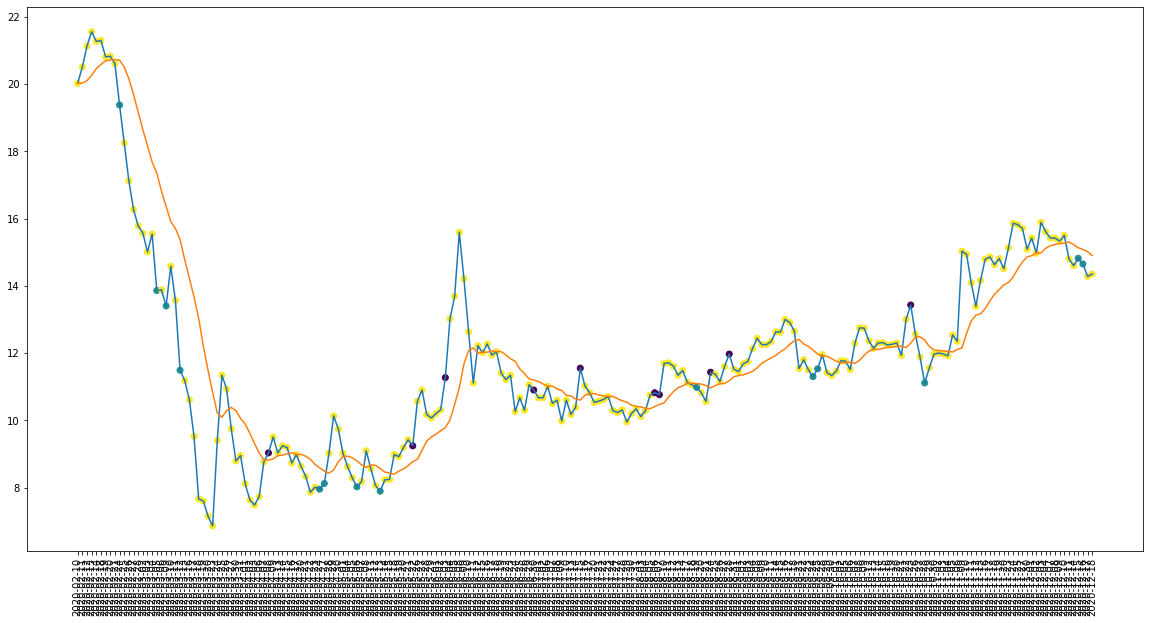

In [49]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [50]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))
logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 11
actual holds but predicted buy: 14
actual holds but predicted sell: 9
actual predicted holds: 174
Percentage buys correct: 0.0%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 88.3248730964467%
actual buys: 10
actual sells: 12
actual holds: 197


In [51]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[20.020000457763672, 20.51000022888184, 20.61000061035156, 20.809999465942386, 20.82999992370605, 21.1299991607666, 21.270000457763672, 21.299999237060547, 21.559999465942386]
[15.56999969482422, 15.779999732971193, 16.270000457763672, 17.120000839233402, 18.25, 19.3799991607666, 20.61000061035156, 20.809999465942386, 20.82999992370605]
Percentage buys correct: 71.42857142857143%
Percentage sells correct: 70.0%
Percentage holds correct: 86.15384615384616%


In [52]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $19.3799991607666
Shares owned at the moment: 514
Cash capital at the moment: $11.28680255222207


Stop Loss Activated!

Share price: $18.25
Shares owned at the moment: 0
Cash capital at the moment: $9365.990427552222


Share price: $13.859999656677244
Shares owned at the moment: 673
Cash capital at the moment: $12.559264243842335


Stop Loss Activated!

Share price: $13.399999618530273
Shares owned at the moment: 0
Cash capital at the moment: $9005.95895822072


Share price: $13.399999618530273
Shares owned at the moment: 670
Cash capital at the moment: $3.2697145082947827


Stop Loss Activated!

Share price: $11.489999771118164
Shares owned at the moment: 0
Cash capital at the moment: $7680.399236579179


Share price: $11.489999771118164
Shares owned at the moment: 666
Cash capital at the moment: $7.015454433678315


Stop Loss Activated!

Share price: $10.609999656677246
Shares owned at the moment: 0
Cash capital at the moment: $7053.84301140952


Share price: $7.9499998

In [53]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7129.270245856284
profit gained: -28.707297541437153%


In [54]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.678899,30.0%,12.5%,72.0%,62.16216216216216%,73.91304347826087%,85.44303797468355%,-3.129409973249549%,3.010957697467784%
1,0.799087,0.0%,8.333333333333334%,88.3248730964467%,71.42857142857143%,70.0%,86.15384615384616%,18.380099501604963%,-28.707297541437153%


### with DAL stock price

In [55]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/JBLU_data.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2002-05-02,14.761481,13.724947,-5.141986,58104336.0,2.0
2002-05-03,14.562963,13.853872,-13.413429,57315261.0,2.0
2002-05-06,15.419259,14.094701,-0.086583,58757399.0,0.0
2002-05-07,16.148148,14.410616,-4.436861,61163774.0,2.0
2002-05-08,14.696296,14.454567,-37.883964,57784724.0,2.0


In [56]:
df2 = pd.read_csv("data/variation 6/initial_indicators/DAL_data.csv")
df2.set_index('Date', inplace=True)
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2007-05-23,19.480000,19.446154,-62.849899,22231100.0,2.0
2007-05-24,19.209999,19.409822,-64.264305,19844000.0,2.0
2007-05-25,19.020000,19.349850,-69.418965,17482000.0,2.0
2007-05-29,18.760000,19.259104,-66.055061,16587000.0,2.0
2007-05-30,19.090000,19.233088,-50.917452,19505800.0,2.0


In [57]:
labels = df['labels'].values
df.drop(['labels'], axis='columns', inplace=True)
df['support'] = df2['previous_1d']
df['labels'] = labels
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,support,labels
Date,,,,,,
2007-05-23,11.10,10.685789,-10.576890,-70068416.0,19.480000,2.0
2007-05-24,10.90,10.718745,-32.978783,-75520116.0,19.209999,2.0
2007-05-25,10.83,10.735861,-42.222253,-79888316.0,19.020000,2.0
2007-05-29,10.84,10.751882,-41.111116,-78160416.0,18.760000,2.0
2007-05-30,10.88,10.771593,-38.372099,-70811516.0,19.090000,2.0


In [58]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [59]:
X = sequential
X  = np.array(X).reshape(-1, 15, 5)
y = labels
y = np.array(y)
X.shape

(2902, 15, 5)

In [60]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [61]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [62]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [63]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [64]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
19/19 [==============================] - 1s 55ms/step - loss: 0.3297 - accuracy: 0.5704 - mse: 0.3830 - weighted_accuracy: 0.2940 - weighted_mse: 0.4863 - val_loss: 0.3019 - val_accuracy: 0.0448 - val_mse: 0.3454 - val_weighted_accuracy: 0.0448 - val_weighted_mse: 0.3454
Epoch 2/200
19/19 [==============================] - 0s 12ms/step - loss: 0.2465 - accuracy: 0.4808 - mse: 0.5619 - weighted_accuracy: 0.3572 - weighted_mse: 0.6009 - val_loss: 0.2990 - val_accuracy: 0.0448 - val_mse: 0.3585 - val_weighted_accuracy: 0.0448 - val_weighted_mse: 0.3585
Epoch 3/200
19/19 [==============================] - 0s 12ms/step - loss: 0.2144 - accuracy: 0.3649 - mse: 0.7606 - weighted_accuracy: 0.4296 - weighted_mse: 0.7521 - val_loss: 0.2930 - val_accuracy: 0.0448 - val_mse: 0.3742 - val_weighted_accuracy: 0.0448 - val_weighted_mse: 0.3742
Epoch 4/200
19/19 [==============================] - 0s 12ms/step - loss: 0.1988 - accuracy: 0.3098 - mse: 0.9219 - weighted_accuracy: 0.4845 - weig

Epoch 30/200
19/19 [==============================] - 0s 12ms/step - loss: 0.1336 - accuracy: 0.4946 - mse: 1.4522 - weighted_accuracy: 0.7604 - weighted_mse: 1.3835 - val_loss: 0.1871 - val_accuracy: 0.3976 - val_mse: 1.2433 - val_weighted_accuracy: 0.3976 - val_weighted_mse: 1.2433
Epoch 31/200
19/19 [==============================] - 0s 12ms/step - loss: 0.1305 - accuracy: 0.5183 - mse: 1.4519 - weighted_accuracy: 0.7782 - weighted_mse: 1.3837 - val_loss: 0.1930 - val_accuracy: 0.3322 - val_mse: 1.2984 - val_weighted_accuracy: 0.3322 - val_weighted_mse: 1.2984
Epoch 32/200
19/19 [==============================] - 0s 13ms/step - loss: 0.1307 - accuracy: 0.5166 - mse: 1.4458 - weighted_accuracy: 0.7777 - weighted_mse: 1.3848 - val_loss: 0.1848 - val_accuracy: 0.4131 - val_mse: 1.2934 - val_weighted_accuracy: 0.4131 - val_weighted_mse: 1.2934
Epoch 33/200
19/19 [==============================] - 0s 15ms/step - loss: 0.1320 - accuracy: 0.4278 - mse: 1.5253 - weighted_accuracy: 0.7422 - 

Epoch 59/200
19/19 [==============================] - 0s 10ms/step - loss: 0.1015 - accuracy: 0.6312 - mse: 1.9074 - weighted_accuracy: 0.8528 - weighted_mse: 1.9168 - val_loss: 0.1803 - val_accuracy: 0.5473 - val_mse: 2.0212 - val_weighted_accuracy: 0.5473 - val_weighted_mse: 2.0212
Epoch 60/200
19/19 [==============================] - 0s 11ms/step - loss: 0.0993 - accuracy: 0.6545 - mse: 1.9043 - weighted_accuracy: 0.8613 - weighted_mse: 1.9092 - val_loss: 0.1671 - val_accuracy: 0.5783 - val_mse: 1.9941 - val_weighted_accuracy: 0.5783 - val_weighted_mse: 1.9941
Epoch 61/200
19/19 [==============================] - 0s 11ms/step - loss: 0.0960 - accuracy: 0.6782 - mse: 1.8896 - weighted_accuracy: 0.8670 - weighted_mse: 1.9097 - val_loss: 0.1769 - val_accuracy: 0.5473 - val_mse: 2.0353 - val_weighted_accuracy: 0.5473 - val_weighted_mse: 2.0353
Epoch 62/200
19/19 [==============================] - 0s 11ms/step - loss: 0.0936 - accuracy: 0.6614 - mse: 1.9559 - weighted_accuracy: 0.8699 - 

Epoch 88/200
19/19 [==============================] - 0s 12ms/step - loss: 0.0759 - accuracy: 0.7497 - mse: 2.5516 - weighted_accuracy: 0.8961 - weighted_mse: 2.6228 - val_loss: 0.1665 - val_accuracy: 0.6196 - val_mse: 2.6536 - val_weighted_accuracy: 0.6196 - val_weighted_mse: 2.6536
Epoch 89/200
19/19 [==============================] - 0s 13ms/step - loss: 0.0766 - accuracy: 0.7264 - mse: 2.5997 - weighted_accuracy: 0.8907 - weighted_mse: 2.6756 - val_loss: 0.2029 - val_accuracy: 0.5387 - val_mse: 2.7747 - val_weighted_accuracy: 0.5387 - val_weighted_mse: 2.7747
Epoch 90/200
19/19 [==============================] - 0s 12ms/step - loss: 0.0778 - accuracy: 0.7523 - mse: 2.5953 - weighted_accuracy: 0.9001 - weighted_mse: 2.6628 - val_loss: 0.1696 - val_accuracy: 0.6265 - val_mse: 2.7930 - val_weighted_accuracy: 0.6265 - val_weighted_mse: 2.7930
Epoch 91/200
19/19 [==============================] - 0s 12ms/step - loss: 0.0747 - accuracy: 0.7579 - mse: 2.6178 - weighted_accuracy: 0.9113 - 

Epoch 117/200
19/19 [==============================] - 0s 13ms/step - loss: 0.0552 - accuracy: 0.8272 - mse: 3.3167 - weighted_accuracy: 0.9336 - weighted_mse: 3.4132 - val_loss: 0.1543 - val_accuracy: 0.6816 - val_mse: 3.4721 - val_weighted_accuracy: 0.6816 - val_weighted_mse: 3.4721
Epoch 118/200
19/19 [==============================] - 0s 13ms/step - loss: 0.0545 - accuracy: 0.8346 - mse: 3.4336 - weighted_accuracy: 0.9394 - weighted_mse: 3.4852 - val_loss: 0.1303 - val_accuracy: 0.7556 - val_mse: 3.6627 - val_weighted_accuracy: 0.7556 - val_weighted_mse: 3.6627
Epoch 119/200
19/19 [==============================] - 0s 13ms/step - loss: 0.0556 - accuracy: 0.8419 - mse: 3.5133 - weighted_accuracy: 0.9420 - weighted_mse: 3.5988 - val_loss: 0.1553 - val_accuracy: 0.7005 - val_mse: 3.6061 - val_weighted_accuracy: 0.7005 - val_weighted_mse: 3.6061
Epoch 120/200
19/19 [==============================] - 0s 13ms/step - loss: 0.0584 - accuracy: 0.8126 - mse: 3.5579 - weighted_accuracy: 0.931

Epoch 146/200
19/19 [==============================] - 0s 14ms/step - loss: 0.0539 - accuracy: 0.8470 - mse: 4.3449 - weighted_accuracy: 0.9348 - weighted_mse: 4.3260 - val_loss: 0.1914 - val_accuracy: 0.6299 - val_mse: 4.6984 - val_weighted_accuracy: 0.6299 - val_weighted_mse: 4.6984
Epoch 147/200
19/19 [==============================] - 0s 12ms/step - loss: 0.0541 - accuracy: 0.8173 - mse: 4.3325 - weighted_accuracy: 0.9270 - weighted_mse: 4.3433 - val_loss: 0.1839 - val_accuracy: 0.6730 - val_mse: 4.4113 - val_weighted_accuracy: 0.6730 - val_weighted_mse: 4.4113
Epoch 148/200
19/19 [==============================] - 0s 12ms/step - loss: 0.0521 - accuracy: 0.8453 - mse: 4.2423 - weighted_accuracy: 0.9403 - weighted_mse: 4.2786 - val_loss: 0.1960 - val_accuracy: 0.6506 - val_mse: 4.1604 - val_weighted_accuracy: 0.6506 - val_weighted_mse: 4.1604
Epoch 149/200
19/19 [==============================] - 0s 13ms/step - loss: 0.0466 - accuracy: 0.8664 - mse: 4.3170 - weighted_accuracy: 0.951

Epoch 175/200
19/19 [==============================] - 0s 17ms/step - loss: 0.0424 - accuracy: 0.8703 - mse: 5.4219 - weighted_accuracy: 0.9525 - weighted_mse: 5.3222 - val_loss: 0.1641 - val_accuracy: 0.7814 - val_mse: 6.1824 - val_weighted_accuracy: 0.7814 - val_weighted_mse: 6.1824
Epoch 176/200
19/19 [==============================] - 0s 16ms/step - loss: 0.0384 - accuracy: 0.8931 - mse: 5.3891 - weighted_accuracy: 0.9608 - weighted_mse: 5.2716 - val_loss: 0.1718 - val_accuracy: 0.7453 - val_mse: 5.4501 - val_weighted_accuracy: 0.7453 - val_weighted_mse: 5.4501
Epoch 177/200
19/19 [==============================] - 0s 18ms/step - loss: 0.0364 - accuracy: 0.9035 - mse: 5.4862 - weighted_accuracy: 0.9646 - weighted_mse: 5.3849 - val_loss: 0.1716 - val_accuracy: 0.7522 - val_mse: 5.4333 - val_weighted_accuracy: 0.7522 - val_weighted_mse: 5.4333
Epoch 178/200
19/19 [==============================] - 0s 17ms/step - loss: 0.0376 - accuracy: 0.9031 - mse: 5.5898 - weighted_accuracy: 0.958

In [65]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1747811734676361
Test accuracy: 0.7659208178520203


In [66]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-3.0627851  -2.6274047   1.660107  ]
 [-3.0651817  -3.4098527   2.26516   ]
 [ 1.0549341  -3.9279552  -1.1976843 ]
 ...
 [-1.6756209  -3.6983695   0.7799706 ]
 [-2.8334818  -1.8182546   0.92305386]
 [-2.1204855  -2.315121    0.8360765 ]]


Counter({2: 492, 0: 40, 1: 49})

In [67]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 529, 0: 26, 1: 26})

In [68]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 581
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 24
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 25
actual holds but predicted buy: 48
actual holds but predicted sell: 38
actual predicted holds: 443
Percentage buys correct: 3.8461538461538463%
Percentage sells correct: 3.8461538461538463%
Percentage holds correct: 83.7429111531191%
actual buys: 26
actual sells: 26
actual holds: 529


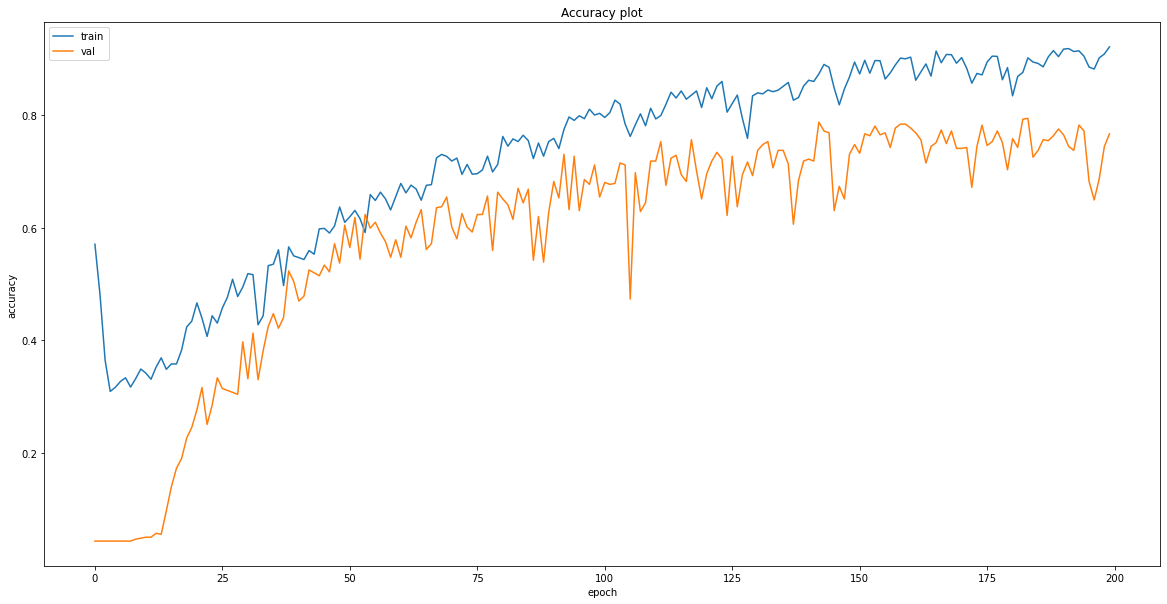

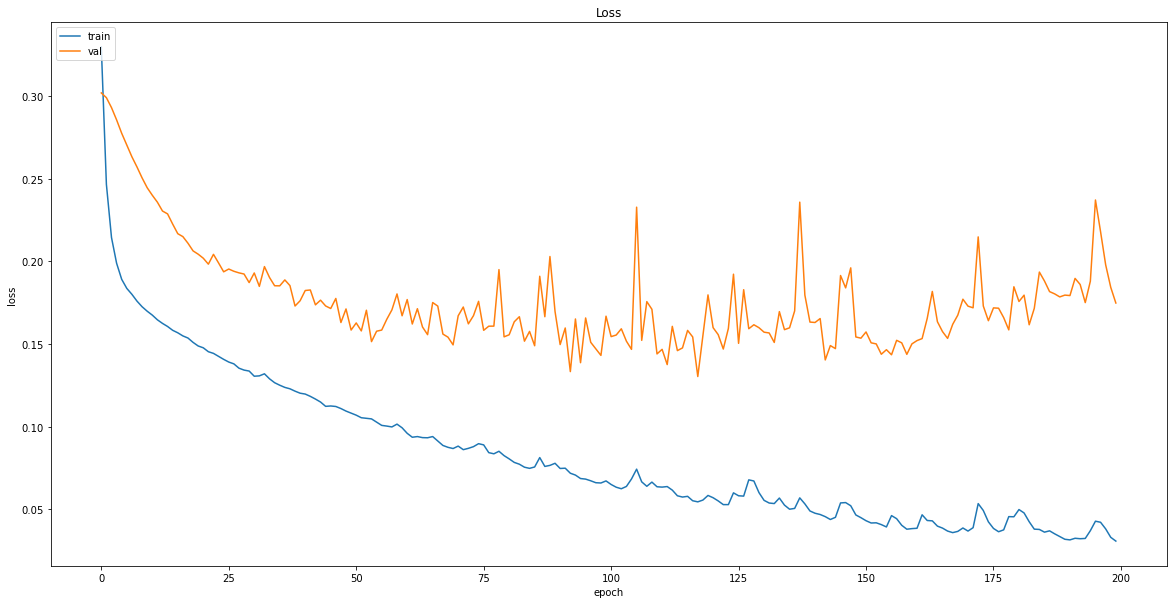

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [70]:
# Save model
model.save("models/{}".format('JBLU_support_time_series_lstm_buy_hold_sell.model'))

INFO:tensorflow:Assets written to: models/JBLU_support_time_series_lstm_buy_hold_sell.model\assets


### Test Performance

### non-recession

In [71]:
logger = []

In [72]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/JBLU_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    17.600000  17.005903  -4.149392  23132100.0     2.0
2019-01-23    17.370001  17.061918 -14.049519  19087600.0     2.0
2019-01-24    17.240000  17.089315 -19.421466  14999400.0     2.0
2019-01-25    18.120001  17.247882  -5.555506  23032100.0     2.0
2019-01-28    17.709999  17.318977 -26.363710  14531900.0     2.0


In [73]:
df2 = pd.read_csv("data/variation 6/initial_indicators/DAL_data_test.csv")
df2.set_index('Date', inplace=True)
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-01-22,48.110001,48.138043,-45.698927,9500900.0,1.0
2019-01-23,47.099998,47.978344,-60.236271,1356500.0,2.0
2019-01-24,47.299999,47.873983,-47.268459,9456400.0,2.0
2019-01-25,47.520000,47.819524,-51.008641,18513600.0,2.0
2019-01-28,47.689999,47.799597,-46.109560,30352800.0,2.0


In [74]:
labels = df['labels'].values
df.drop(['labels'], axis='columns', inplace=True)
df['support'] = df2['previous_1d']
df['labels'] = labels
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,support,labels
Date,,,,,,
2019-01-22,17.600000,17.005903,-4.149392,23132100.0,48.110001,2.0
2019-01-23,17.370001,17.061918,-14.049519,19087600.0,47.099998,2.0
2019-01-24,17.240000,17.089315,-19.421466,14999400.0,47.299999,2.0
2019-01-25,18.120001,17.247882,-5.555506,23032100.0,47.520000,2.0
2019-01-28,17.709999,17.318977,-26.363710,14531900.0,47.689999,2.0


In [75]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [76]:
X = sequential
X  = np.array(X).reshape(-1, 15, 5)
y = labels
y = np.array(y)
X.shape

(218, 15, 5)

In [77]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [78]:
model = tf.keras.models.load_model("models/JBLU_support_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

7/7 [==============================] - 0s 4ms/step - loss: 0.1774 - accuracy: 0.7798 - mean_squared_error: 6.6958 - weighted_accuracy: 0.7798 - weighted_mean_squared_error: 6.6958
Test loss: 0.17742013931274414
Test accuracy: 0.7798165082931519


In [79]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 182, 1: 16, 0: 20})

In [80]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({0: 8, 2: 200, 1: 10})

In [81]:
df = pd.read_csv("data/variation 6/initial_indicators/JBLU_data_test.csv")
df.set_index('Date', inplace=True)

In [82]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,18.260000,17.940004,-24.657592,14449900.0,0.0,2,0
2019-02-12,17.889999,17.989234,-16.438351,18367600.0,2.0,2,2
2019-02-13,18.049999,17.973967,-53.508854,14230800.0,2.0,2,2
2019-02-14,18.080000,17.985665,-50.000106,18206400.0,2.0,2,2
2019-02-15,17.959999,18.000178,-46.666695,20743900.0,2.0,2,2


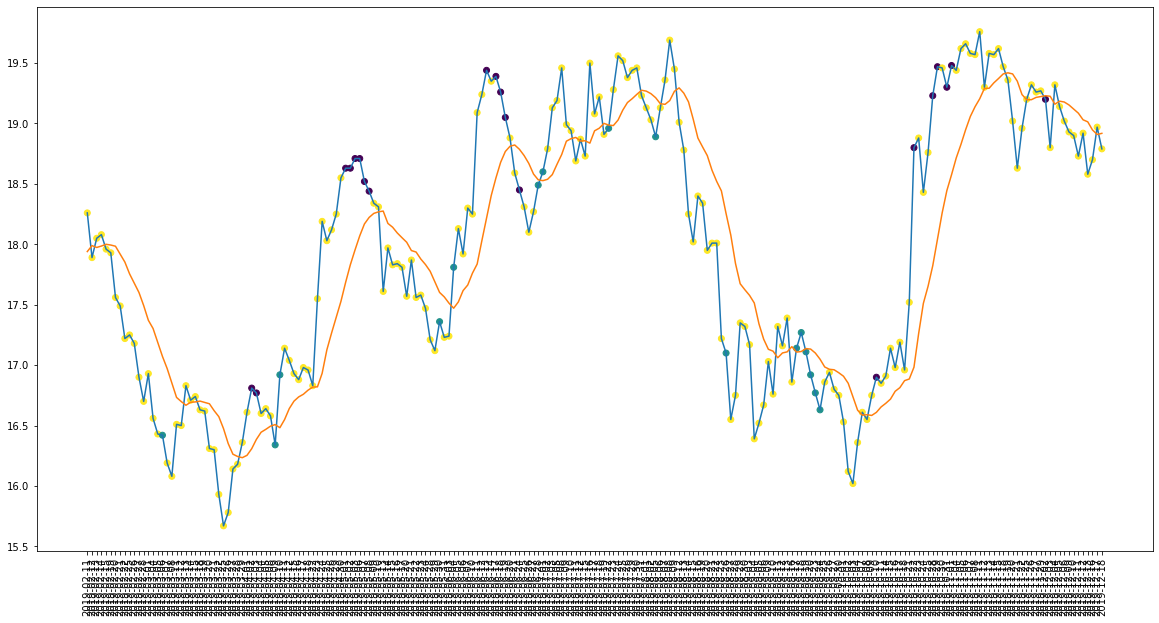

In [83]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

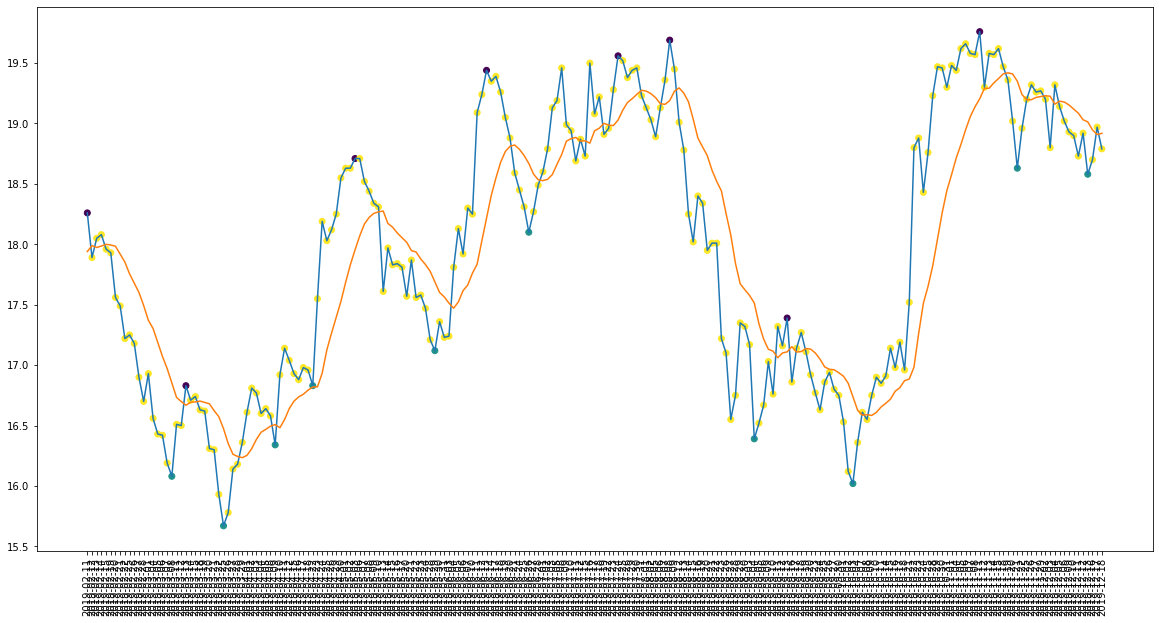

In [84]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [85]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 6
actual holds but predicted buy: 15
actual holds but predicted sell: 18
actual predicted holds: 167
Percentage buys correct: 10.0%
Percentage sells correct: 25.0%
Percentage holds correct: 83.5%
actual buys: 10
actual sells: 8
actual holds: 200


In [86]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[17.219999313354492, 17.489999771118164, 17.559999465942386, 17.889999389648438, 17.93000030517578, 17.959999084472656, 18.049999237060547, 18.07999992370605, 18.26000022888184]
[16.559999465942386, 16.700000762939453, 16.899999618530273, 16.930000305175778, 17.180000305175778, 17.219999313354492, 17.25, 17.489999771118164, 17.559999465942386]
Percentage buys correct: 43.75%
Percentage sells correct: 65.0%
Percentage holds correct: 83.42541436464089%


In [87]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $16.420000076293945
Shares owned at the moment: 607
Cash capital at the moment: $5.650868562221149


Stop Loss Activated!

Share price: $15.93000030517578
Shares owned at the moment: 0
Cash capital at the moment: $9648.569900794504


Share price: $16.34000015258789
Shares owned at the moment: 588
Cash capital at the moment: $14.228030826088798


Price increase from previously bought: 13.702001178485013%
Share price: $18.6299991607666
Shares owned at the moment: 0
Cash capital at the moment: $10938.542828713891


Share price: $17.360000610351562
Shares owned at the moment: 628
Cash capital at the moment: $6.481724359033251


Price increase from previously bought: 11.674461191265362%
Share price: $19.440000534057614
Shares owned at the moment: 0
Cash capital at the moment: $12181.229178824897


Share price: $18.489999771118164
Shares owned at the moment: 656
Cash capital at the moment: $18.43336938428365


Stop Loss Activated!

Share price: $17.950000762939453
Shares owned a

In [88]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10233.749798190114
profit gained: 2.337497981901142%


In [89]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.678899,30.0%,12.5%,72.0%,62.16216216216216%,73.91304347826087%,85.44303797468355%,-3.129409973249549%,3.010957697467784%
1,0.799087,0.0%,8.333333333333334%,88.3248730964467%,71.42857142857143%,70.0%,86.15384615384616%,18.380099501604963%,-28.707297541437153%
2,0.779817,10.0%,25.0%,83.5%,43.75%,65.0%,83.42541436464089%,5.313862967090554%,2.337497981901142%


### recession test data

In [90]:
logger = []

In [91]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/JBLU_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    19.049999  18.785034 -29.629734  -5172900.0     2.0
2020-01-23    19.790001  18.939644 -15.920381   7229600.0     0.0
2020-01-24    21.070000  19.267391  -2.622949  23219300.0     2.0
2020-01-27    20.650000  19.480100 -18.060233  11950900.0     2.0
2020-01-28    20.040001  19.566239 -38.461529   3416600.0     2.0


In [92]:
df2 = pd.read_csv("data/variation 6/initial_indicators/DAL_data_test2.csv")
df2.set_index('Date', inplace=True)
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2020-01-22,60.340000,59.859537,-36.769751,36316500.0,2.0
2020-01-23,59.639999,59.825762,-48.797256,29220100.0,2.0
2020-01-24,60.270000,59.894106,-37.972495,36994600.0,2.0
2020-01-27,58.810001,59.727321,-63.058391,26005100.0,2.0
2020-01-28,56.830002,59.281579,-82.361475,12914900.0,2.0


In [93]:
labels = df['labels'].values
df.drop(['labels'], axis='columns', inplace=True)
df['support'] = df2['previous_1d']
df['labels'] = labels
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,support,labels
Date,,,,,,
2020-01-22,19.049999,18.785034,-29.629734,-5172900.0,60.340000,2.0
2020-01-23,19.790001,18.939644,-15.920381,7229600.0,59.639999,0.0
2020-01-24,21.070000,19.267391,-2.622949,23219300.0,60.270000,2.0
2020-01-27,20.650000,19.480100,-18.060233,11950900.0,58.810001,2.0
2020-01-28,20.040001,19.566239,-38.461529,3416600.0,56.830002,2.0


In [94]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 5)
y = labels
y = np.array(y)
X.shape

(219, 15, 5)

In [95]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [96]:
model = tf.keras.models.load_model("models/JBLU_support_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2070 - accuracy: 0.7991 - mean_squared_error: 6.6279 - weighted_accuracy: 0.7991 - weighted_mean_squared_error: 6.6279
Test loss: 0.20700696110725403
Test accuracy: 0.7990867495536804


In [97]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 194, 1: 14, 0: 11})

In [98]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [99]:
df = pd.read_csv("data/variation 6/initial_indicators/JBLU_data_test2.csv")
df.set_index('Date', inplace=True)

In [100]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,20.510000,20.028004,-60.309266,9053300.0,2.0,2,2
2020-02-12,21.129999,20.102157,-43.870955,13857200.0,2.0,2,2
2020-02-13,21.559999,20.260287,-12.352994,18449600.0,0.0,2,0
2020-02-14,21.270000,20.460243,-1.538496,23393200.0,2.0,2,2
2020-02-18,21.299999,20.584821,-18.905429,17925800.0,2.0,2,2


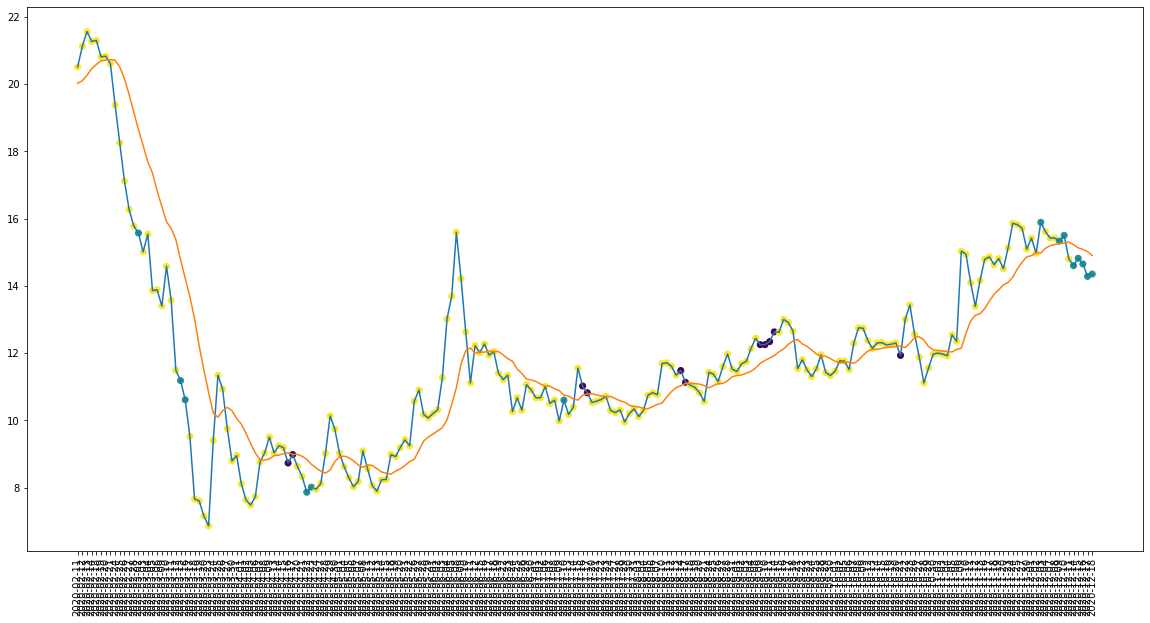

In [101]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

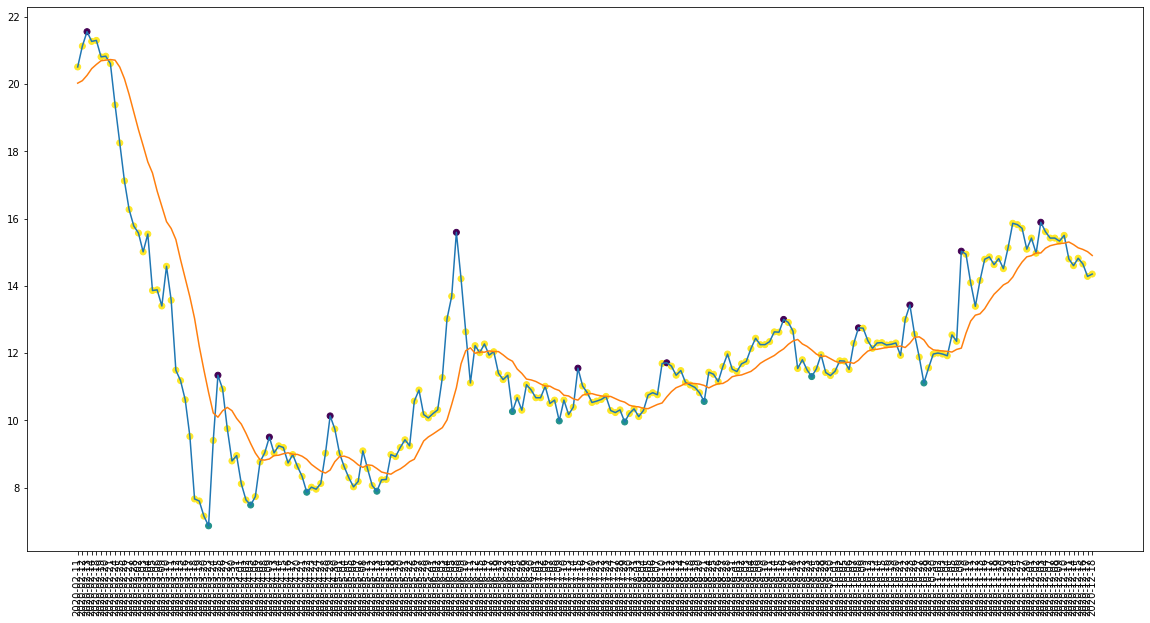

In [102]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [103]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 11
actual holds but predicted buy: 12
actual holds but predicted sell: 11
actual predicted holds: 174
Percentage buys correct: 10.0%
Percentage sells correct: 0.0%
Percentage holds correct: 88.3248730964467%
actual buys: 10
actual sells: 12
actual holds: 197


In [104]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[19.3799991607666, 20.51000022888184, 20.61000061035156, 20.809999465942386, 20.82999992370605, 21.1299991607666, 21.270000457763672, 21.299999237060547, 21.559999465942386]
[15.010000228881836, 15.56999969482422, 15.779999732971193, 16.270000457763672, 17.120000839233402, 18.25, 19.3799991607666, 20.61000061035156, 20.82999992370605]
Percentage buys correct: 50.0%
Percentage sells correct: 45.45454545454545%
Percentage holds correct: 84.4559585492228%


In [105]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $15.56999969482422
Shares owned at the moment: 640
Cash capital at the moment: $7.796995849606901


Stop Loss Activated!

Share price: $15.010000228881836
Shares owned at the moment: 0
Cash capital at the moment: $9587.77954193115


Share price: $11.18000030517578
Shares owned at the moment: 855
Cash capital at the moment: $2.5923052883135824


Stop Loss Activated!

Share price: $10.609999656677246
Shares owned at the moment: 0
Cash capital at the moment: $9049.195250054596


Share price: $10.609999656677246
Shares owned at the moment: 850
Cash capital at the moment: $5.894667681453939


Stop Loss Activated!

Share price: $9.520000457763672
Shares owned at the moment: 0
Cash capital at the moment: $8075.642055710552


Share price: $7.860000133514402
Shares owned at the moment: 1024
Cash capital at the moment: $4.868158615828179


Price increase from previously bought: 39.81906335911765%
Share price: $11.020000457763672
Shares owned at the moment: 0
Cash capital at the mome

In [106]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $6959.649683341978
profit gained: -30.40350316658022%


In [107]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.678899,30.0%,12.5%,72.0%,62.16216216216216%,73.91304347826087%,85.44303797468355%,-3.129409973249549%,3.010957697467784%
1,0.799087,0.0%,8.333333333333334%,88.3248730964467%,71.42857142857143%,70.0%,86.15384615384616%,18.380099501604963%,-28.707297541437153%
2,0.779817,10.0%,25.0%,83.5%,43.75%,65.0%,83.42541436464089%,5.313862967090554%,2.337497981901142%
3,0.799087,10.0%,0.0%,88.3248730964467%,50.0%,45.45454545454545%,84.4559585492228%,1.983464435460537%,-30.40350316658022%


In [108]:
experiment

'JBLU Variation 6 LSTM Time Series'

In [109]:
log.to_csv('{}.csv'.format(experiment))